<a href="https://colab.research.google.com/github/KaziMuktadirAhmed/WISER-womenium-2025-project-1/blob/main/noise_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:


# Step 1: Run this cell first to install all necessary packages.
# After this finishes, you MUST restart the runtime.
# Go to the menu: Runtime -> Restart session
!pip install -q qiskit qiskit-aer matplotlib pylatexenc
!pip install qiskit-ibm-runtime
!pip install qiskit-ibm-transpiler[ai-local-mode]
!pip install qiskit-transpiler-service

!pip install qiskit[ai]
print("✅ All packages installed successfully. Please restart the runtime now.")



✅ All packages installed successfully. Please restart the runtime now.


In [3]:
import os
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer.primitives import Sampler
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeManhattanV2, FakeTorino,FakeKawasaki,FakeOsaka,FakeTorino,FakeMarrakesh
from qiskit_aer.noise import NoiseModel
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from collections import defaultdict
import os
import math

In [15]:
try:
    from IPython.display import display
    IS_IPYTHON = True
except ImportError:
    IS_IPYTHON = False

#Gaussian Distribution

In [16]:
# --- Original functions from the cell ---
def create_n_layer_qgb(n_layers: int):
    """
    Generates an optimized Qiskit QuantumCircuit for an N-layer Quantum Galton Board.

    Args:
        n_layers: The number of peg layers in the Galton board.

    Returns:
        A Qiskit QuantumCircuit object for the N-layer QGB.
    """
    num_working_qubits = 2 * n_layers + 1
    num_qubits = num_working_qubits + 1
    num_clbits = n_layers + 1

    qc = QuantumCircuit(num_qubits, num_clbits, name=f"{n_layers}-Layer QGB")

    control_qubit = 0

    # --- Step 1: Initialization ---
    initial_ball_pos = n_layers + 1
    qc.x(initial_ball_pos)
    # Prepare control qubit for the first layer
    qc.h(control_qubit)
    qc.barrier()

    # --- Step 2: Build the Layers ---
    for layer in range(n_layers):
        # --- Peg Logic for the current layer ---
        peg_positions = range(n_layers + 1 - layer, n_layers + 1 + layer + 1, 2)

        for i, peg_pos in enumerate(peg_positions):
            left_channel = peg_pos - 1
            right_channel = peg_pos + 1

            # Apply the standard "quantum peg" logic
            qc.cswap(control_qubit, left_channel, peg_pos)
            qc.cx(peg_pos, control_qubit)
            qc.cswap(control_qubit, peg_pos, right_channel)

            # Rebalancing CNOT for pegs within the same layer
            if i < len(peg_positions) - 1:
                qc.cx(right_channel, control_qubit)

        qc.barrier()

        # --- OPTIMIZED Control Qubit Preparation for the *next* layer ---
        if layer < n_layers - 1:  # No need to prepare after the last layer
            if layer == 0:
                # After layer 0 (1 peg), control qubit is in state |1>.
                # Optimize by flipping to |0> then applying Hadamard.
                # This is more efficient than a full reset.
                qc.x(control_qubit)
                qc.h(control_qubit)
            else:
                # For subsequent layers, state is entangled. Reset is cleanest.
                qc.reset(control_qubit)
                qc.h(control_qubit)
            qc.barrier()

    # --- Step 3: Measurement ---
    output_qubits = range(1, num_working_qubits + 2, 2)
    qc.measure(output_qubits, range(num_clbits))

    return qc

#Hadamard Distribution

In [17]:
def create_hadamard_walk_qgb(n_layers: int):
    """
    Generates a Qiskit Circuit for a Quantum Galton Board that performs
    a Hadamard Quantum Walk. This is achieved by using a bias angle of pi/2,
    which is equivalent to using a Hadamard gate as the "coin" at each step.

    Args:
        n_layers: The number of peg layers in the Galton board.

    Returns:
        A Qiskit QuantumCircuit object for the Hadamard Walk QGB.
    """
    num_working_qubits = 2 * n_layers + 1
    num_qubits = num_working_qubits + 1
    num_clbits = n_layers + 1

    qc = QuantumCircuit(num_qubits, num_clbits, name=f"{n_layers}-Layer Hadamard Walk")

    control_qubit = 0
    bias_angle = np.pi / 2  # This angle makes the Rx gate act like a Hadamard

    # --- Step 1: Initialization ---
    initial_ball_pos = n_layers + 1
    qc.x(initial_ball_pos)
    qc.rx(bias_angle, control_qubit)
    qc.barrier()

    # --- Step 2: Build the Layers ---
    for layer in range(n_layers):
        peg_positions = range(n_layers + 1 - layer, n_layers + 1 + layer + 1, 2)

        for i, peg_pos in enumerate(peg_positions):
            left_channel = peg_pos - 1
            right_channel = peg_pos + 1

            qc.cswap(control_qubit, left_channel, peg_pos)
            qc.cx(peg_pos, control_qubit)
            qc.cswap(control_qubit, peg_pos, right_channel)

            if i < len(peg_positions) - 1:
                qc.cx(right_channel, control_qubit)

        qc.barrier()

        if layer < n_layers - 1:
            # qc.reset(control_qubit)
            # qc.rx(bias_angle, control_qubit)
            qc.h(control_qubit)
            qc.barrier()

    # --- Step 3: Measurement ---
    output_qubits = range(1, num_working_qubits + 2, 2)
    qc.measure(output_qubits, range(num_clbits))

    return qc

#Exponential Distribution

In [18]:
def create_exponential_dist(n_layers: int, target_distribution="exponential_custom"):
    """
    Generates a Qiskit QuantumCircuit for an N-layer Quantum Galton Board with a left-skewed exponential distribution.
    """
    num_working_qubits = 2 * n_layers + 1
    num_qubits = num_working_qubits + 1
    num_clbits = n_layers + 1

    qc = QuantumCircuit(num_qubits, num_clbits, name=f"{n_layers}-Layer QGB")

    control_qubit = 0

    # --- Step 1: Initialization ---
    initial_ball_pos = n_layers + 1
    qc.x(initial_ball_pos)

    qc.barrier()

    # --- Step 2: Build the Layers ---
    for layer in range(n_layers):
        qc.reset(control_qubit)

        base_bias = 30 * (np.pi/180)
        qc.rx(base_bias, control_qubit)

        peg_positions = range(n_layers + 1 - layer, n_layers + 1 + layer + 1, 2)

        for i, peg_pos in enumerate(peg_positions):
            left_channel = peg_pos - 1
            right_channel = peg_pos + 1

            qc.cswap(control_qubit, left_channel, peg_pos)
            qc.cx(peg_pos, control_qubit)
            qc.cswap(control_qubit, peg_pos, right_channel)

            if i < len(peg_positions) - 1:
                qc.cx(right_channel, control_qubit)

        qc.barrier()

    # --- Step 3: Measurement ---
    output_qubits = range(1, num_working_qubits + 2, 2)
    qc.measure(output_qubits, range(num_clbits))

    return qc

# Three Types of Distance Measurement
1. Total Variation Distance.
2. Wasserstein Distance.
3. Jensen Shannon Divergence.


In [19]:
def total_variation_distance(p, q):
    """Calculates the Total Variation Distance between two probability distributions."""
    keys = sorted(list(set(p.keys()).union(set(q.keys()))))
    tvd = 0.0
    for key in keys:
        tvd += abs(p.get(key, 0.0) - q.get(key, 0.0))
    return tvd / 2.0

def jensen_shannon_divergence(p, q):
    """Calculates the Jensen-Shannon Divergence between two probability distributions."""
    keys = sorted(list(set(p.keys()).union(set(q.keys()))))
    m = defaultdict(float)
    for key in keys:
        m[key] = (p.get(key, 0.0) + q.get(key, 0.0)) / 2.0

    jsd = 0.0
    for key in keys:
        if p.get(key, 0.0) > 0:
            jsd += p.get(key, 0.0) * math.log2(p.get(key, 0.0) / m[key])
        if q.get(key, 0.0) > 0:
            jsd += q.get(key, 0.0) * math.log2(q.get(key, 0.0) / m[key])

    return math.sqrt(jsd / 2.0)

def wasserstein_distance(p, q):
    """Calculates the 1D Wasserstein Distance between two probability distributions."""
    keys = sorted(list(set(p.keys()).union(set(q.keys()))))
    cdf_p = {}
    cdf_q = {}
    current_cdf_p = 0.0
    current_cdf_q = 0.0

    for key in keys:
        current_cdf_p += p.get(key, 0.0)
        current_cdf_q += q.get(key, 0.0)
        cdf_p[key] = current_cdf_p
        cdf_q[key] = current_cdf_q

    wd = 0.0
    prev_key = keys[0]
    for i in range(1, len(keys)):
        key = keys[i]
        wd += (key - prev_key) * abs(cdf_p[prev_key] - cdf_q[prev_key])
        prev_key = key

    return wd

#Plotting The Distance

In [20]:
def plot_distance_metrics(distances):
    """Plots a bar chart of distance metrics."""
    names = list(distances.keys())
    values = list(distances.values())

    plt.figure(figsize=(8, 5))
    bars = plt.bar(names, values, color=['blue', 'orange', 'green'])
    plt.title('Comparison of Distance Metrics')
    plt.ylabel('Value')
    plt.grid(axis='y', alpha=0.3)
    for bar, val in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() * 1.01,
                 f"{val:.4f}", ha='center', va='bottom')
    plt.tight_layout()
    if IS_IPYTHON:
        display(plt.gcf())
    else:
        plt.show()
    plt.close()

#Get available devices

In [21]:
def get_available_devices():
    """
    List available fake backend devices
    """
    devices = {
        'torino': FakeTorino

    }
    return devices

#Using IBM's Fake Backend Devices and Running Noisy Simulations

In [22]:
def run_noisy_simulation(circuit, shots=8192, device_name='manhattan'):
    """
    Run the circuit with device noise model simulation
    """
    # Get available devices
    devices = get_available_devices()

    # Create fake device backend
    if device_name.lower() in devices:
        fake_device = devices[device_name.lower()]()
    else:
        print(f"Unknown device '{device_name}'. Available devices: {list(devices.keys())}")
        print("Using default: FakeManhattanV2")
        fake_device = FakeManhattanV2()

    print(f"Using device: {fake_device.name}")
    print(f"Circuit requires {circuit.num_qubits} qubits, device has {fake_device.num_qubits} qubits")

    # Check if circuit fits on device
    if circuit.num_qubits > fake_device.num_qubits:
        print(f"WARNING: Circuit needs {circuit.num_qubits} qubits but device only has {fake_device.num_qubits}")
        print("Falling back to noise-model-only simulation (no coupling map constraints)")

        # Create noise model from the fake device
        noise_model = NoiseModel.from_backend(fake_device)

        # Create AerSimulator with noise model
        sim_noisy = AerSimulator(noise_model=noise_model)

        # Transpile with basic optimization only
        transpiled_circuit = transpile(circuit, sim_noisy, optimization_level=3)

    else:
        # Create noise model from the fake device
        noise_model = NoiseModel.from_backend(fake_device)

        # Get device properties
        coupling_map = fake_device.coupling_map
        basis_gates = fake_device.basis_gates

        # Create AerSimulator with noise model
        sim_noisy = AerSimulator(
            noise_model=noise_model,
            coupling_map=coupling_map,
            basis_gates=basis_gates
        )

        # Transpile circuit for the noisy backend with higher optimization
        try:
            transpiled_circuit = transpile(circuit, sim_noisy, optimization_level=3)
        except Exception as e:
            print(f"High optimization failed: {e}")
            print("Trying with coupling map disabled...")
            sim_noisy = AerSimulator(noise_model=noise_model)
            transpiled_circuit = transpile(circuit, sim_noisy, optimization_level=3)


    print(f"Original circuit depth: {circuit.depth()}")
    print(f"Transpiled circuit depth: {transpiled_circuit.depth()}")
    print(f"Number of qubits on device: {fake_device.num_qubits}")

    # Run the noisy simulation
    job = sim_noisy.run(transpiled_circuit, shots=shots)
    result = job.result()
    counts = result.get_counts(0)

    return counts, noise_model, transpiled_circuit # Return transpiled_circuit

#Comparing Noisy and Ideal Simulations via Plot

In [23]:
def compare_ideal_vs_noisy(circuit, n_layers, shots=8192, device_name='manhattan'):
    """
    Compare ideal simulation vs noisy simulation results
    """
    print("=== IDEAL SIMULATION ===")

    # Use the original Sampler (V1) for compatibility
    sampler = Sampler()
    job = sampler.run(circuit, shots=shots)
    result = job.result()

    # Get counts from the result
    counts_data = result.quasi_dists[0]

    # Convert quasi-distribution to counts and then to probabilities
    ideal_distribution = defaultdict(float, {i: 0.0 for i in range(n_layers + 1)})

    for outcome, probability in counts_data.items():
        # Convert integer outcome to binary string
        bitstring = format(outcome, f'0{n_layers + 1}b')
        try:
            position = bitstring.index('1')
            ideal_distribution[position] += probability
        except ValueError:
            pass

    print("Ideal Results (Probabilities):")
    print({k: v for k, v in sorted(ideal_distribution.items())})

    print("\n=== NOISY SIMULATION ===")
    # Run noisy simulation and get transpiled circuit
    noisy_counts, noise_model, transpiled_circuit = run_noisy_simulation(circuit, shots, device_name)

    # Convert counts to probabilities
    total_shots = sum(noisy_counts.values())
    noisy_distribution = defaultdict(float, {i: 0.0 for i in range(n_layers + 1)})

    for bitstring, count in noisy_counts.items():
        prob = count / total_shots
        try:
            position = bitstring.index('1')
            noisy_distribution[position] += prob
        except ValueError:
            pass

    print("Noisy Results (Probabilities):")
    print({k: v for k, v in sorted(noisy_distribution.items())})

    # Plot comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Ideal histogram
    positions = list(ideal_distribution.keys())
    probabilities = list(ideal_distribution.values())
    ax1.bar(positions, probabilities, alpha=0.7, color='blue')
    ax1.set_title(f'Ideal {n_layers}-Layer QGB Distribution')
    ax1.set_xlabel('Position')
    ax1.set_ylabel('Probability')
    ax1.grid(True, alpha=0.3)

    # Noisy histogram
    positions_noisy = list(noisy_distribution.keys())
    probabilities_noisy = list(noisy_distribution.values())
    ax2.bar(positions_noisy, probabilities_noisy, alpha=0.7, color='red')
    ax2.set_title(f'Noisy {n_layers}-Layer QGB Distribution')
    ax2.set_xlabel('Position')
    ax2.set_ylabel('Probability')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save the figure object before displaying or closing
    dist_plot_path = os.path.join(folder_name, f'{n_layers}_layers_qgb.png')
    fig.savefig(dist_plot_path)


    if IS_IPYTHON:
        display(fig)
    else:
        plt.show()
    plt.close(fig) # Close the figure after saving and displaying


    return ideal_distribution, noisy_distribution, noise_model, transpiled_circuit

In [24]:
# Additions for saving results and images
def ensure_folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)


def save_circuit_diagram(circuit, filepath):
    # Draw circuit diagram using mpl and save figure
    fig = circuit.draw(output='mpl')
    fig.savefig(filepath)
    plt.close(fig)


#Saving the results in a file

In [25]:
def save_results_text(filepath, n_layers, device_name, ideal_dist, noisy_dist, tvd, jsd, wd, noise_model, circuit, transpiled_circuit):
    with open(filepath, 'w') as f:
        f.write(f"--- Comparing Ideal vs Noisy Simulation for {n_layers}-Layer QGB ---\n\n")
        f.write("=== IDEAL SIMULATION ===\n")
        f.write(f"Ideal Results (Probabilities):\n{dict(sorted(ideal_dist.items()))}\n\n")
        f.write("=== NOISY SIMULATION ===\n")
        f.write(f"Using device: {device_name}\n")
        f.write(f"Circuit qubits: {circuit.num_qubits}, Device qubits: Unknown\n") # Device qubits might be unknown if falling back to noise-model-only
        f.write(f"Original circuit depth: {circuit.depth()}\n")
        f.write(f"Transpiled circuit depth: {transpiled_circuit.depth()}\n\n") # This line now receives a QuantumCircuit object
        f.write(f"Noisy Results (Probabilities):\n{dict(sorted(noisy_dist.items()))}\n\n")
        f.write("--- Noise Model Information ---\n")
        f.write(f"Device used: {device_name}\n")
        f.write(f"Noise model type: {type(noise_model)}\n")
        f.write(f"Number of noise instructions: "
                f"{len(noise_model._noise_instructions) if hasattr(noise_model, '_noise_instructions') else 'N/A'}\n\n")
        f.write("--- Difference Analysis ---\n")
        for pos in range(n_layers + 1):
            ideal_prob = ideal_dist.get(pos, 0.0)
            noisy_prob = noisy_dist.get(pos, 0.0)
            diff = abs(ideal_prob - noisy_prob)
            f.write(f"Position {pos}: Ideal={ideal_prob:.4f}, Noisy={noisy_prob:.4f}, Diff={diff:.4f}\n")
        f.write(f"\nTotal Variation Distance: {tvd:.4f}\n")
        f.write(f"Jensen-Shannon Divergence: {jsd:.4f}\n")
        f.write(f"Wasserstein Distance: {wd:.4f}\n")


--- Circuit Information for 5-Layer QGB ---
Circuit depth: 61
Number of qubits: 12
Number of classical bits: 6

Circuit diagram:

=== IDEAL SIMULATION ===
Ideal Results (Probabilities):
{0: 0.0283203125, 1: 0.3363037109375, 2: 0.1241455078125, 3: 0.12890625, 4: 0.3470458984375, 5: 0.0352783203125}

=== NOISY SIMULATION ===
Using device: fake_torino


/tmp/ipython-input-4080368494.py:21: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  ideal_dist, noisy_dist, noise_model, transpiled_circuit = compare_ideal_vs_noisy(qgb_circuit, N_LAYERS, SHOTS, TEST_DEVICE) # Capture transpiled_circuit here


Circuit requires 12 qubits, device has 133 qubits
High optimization failed: No node found for index
Trying with coupling map disabled...
Original circuit depth: 61
Transpiled circuit depth: 814
Number of qubits on device: 133
Noisy Results (Probabilities):
{0: 0.0618896484375, 1: 0.2952880859375, 2: 0.1793212890625, 3: 0.1488037109375, 4: 0.2139892578125, 5: 0.0225830078125}


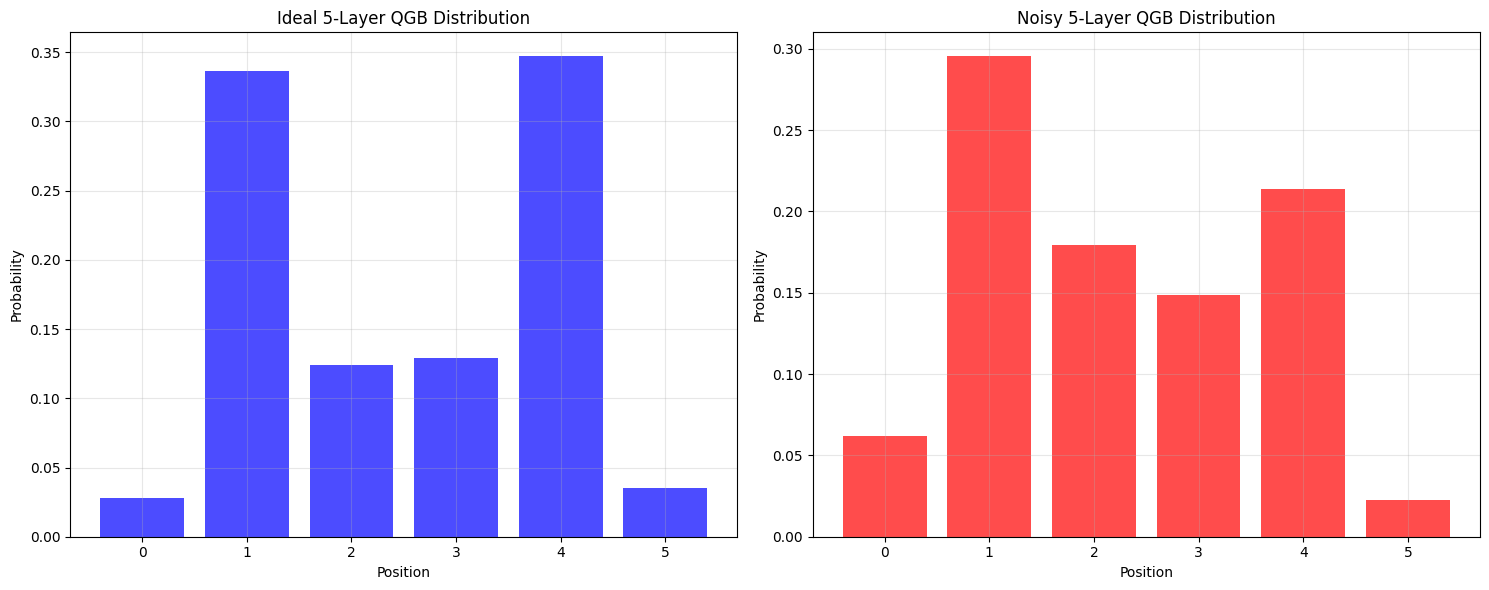

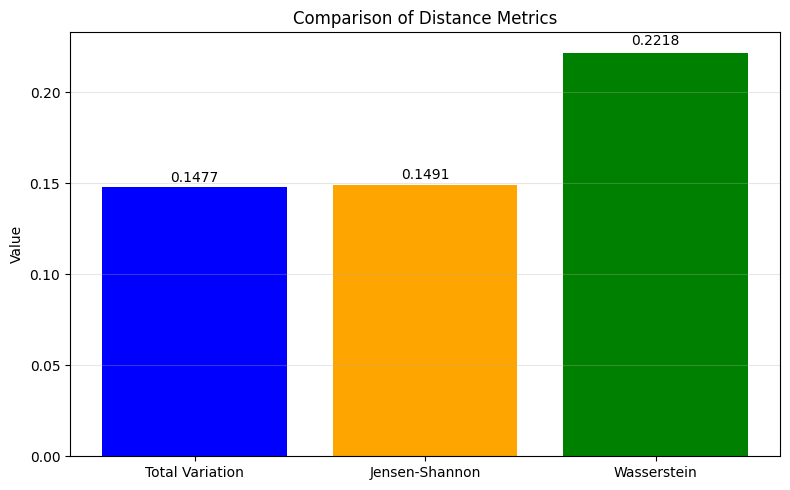


All results and images saved inside folder: 'torino-hadamard'


In [26]:
if __name__ == '__main__':
    N_LAYERS = 5

    TEST_DEVICE = 'torino'
    SHOTS = 8192

    # ----- Create the QGB circuit-----
    qgb_circuit =create_hadamard_walk_qgb(N_LAYERS)

    folder_name = f"{TEST_DEVICE}-hadamard"
    ensure_folder(folder_name)

    # Print circuit stats and diagram
    print(f"\n--- Circuit Information for {N_LAYERS}-Layer QGB ---")
    print(f"Circuit depth: {qgb_circuit.depth()}")
    print(f"Number of qubits: {qgb_circuit.num_qubits}")
    print(f"Number of classical bits: {qgb_circuit.num_clbits}\n")
    print("Circuit diagram:\n")

    # ----- Run simulations and get results, including the transpiled circuit -----
    ideal_dist, noisy_dist, noise_model, transpiled_circuit = compare_ideal_vs_noisy(qgb_circuit, N_LAYERS, SHOTS, TEST_DEVICE) # Capture transpiled_circuit here

    # ----- Calculate distances -----
    tvd = total_variation_distance(ideal_dist, noisy_dist)
    jsd = jensen_shannon_divergence(ideal_dist, noisy_dist)
    wd = wasserstein_distance(ideal_dist, noisy_dist)

    # Plot distance metrics
    plot_distance_metrics({
        'Total Variation': tvd,
        'Jensen-Shannon': jsd,
        'Wasserstein': wd
    })



    # ----- Plot and save distance metrics graph -----
    plt.figure(figsize=(8, 5))
    names = ['Total Variation', 'Jensen-Shannon', 'Wasserstein']
    values = [tvd, jsd, wd]
    bars = plt.bar(names, values, color=['blue', 'orange', 'green'])
    plt.title('Comparison of Distance Metrics')
    plt.ylabel('Value')
    plt.grid(axis='y', alpha=0.3)
    for bar, val in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() * 1.01,
                 f"{val:.4f}", ha='center', va='bottom')
    plt.tight_layout()
    distance_plot_path = os.path.join(folder_name, 'distance.png')
    plt.savefig(distance_plot_path)
    plt.close()

    # ----- Save results text file ------
    results_txt_path = os.path.join(folder_name, 'results.txt')
    save_results_text(results_txt_path, N_LAYERS, TEST_DEVICE, ideal_dist, noisy_dist, tvd, jsd, wd, noise_model, qgb_circuit, transpiled_circuit=transpiled_circuit) # Corrected: pass transpiled_circuit

    # ----- Save circuit diagrams:------
    original_circuit_path = os.path.join(folder_name, 'original_circuit.mpl.png')
    transpiled_circuit_path = os.path.join(folder_name, 'transpiled_circuit.mpl.png')

    save_circuit_diagram(qgb_circuit, original_circuit_path)
    save_circuit_diagram(transpiled_circuit, transpiled_circuit_path)


    print(f"\nAll results and images saved inside folder: '{folder_name}'")

# Experiments on 12 Noise Models and 3 Distributions

1. Noise Models:
   FakeCusco;
   FakeFez;
   FakeKawasaki;
   FakeKyiv;
   FakeKyoto;
   FakeOsaka;
   FakeQuebec;
   FakeSherbrooke;
   FakeTorino;
   FakeWashingtonV2;
   FakeBrisbane;
   FakeMarrakesh;

2. Distributions:
   Hadamard;
   Gaussian;
   Exponential;

3. Each distribution was tested separately on all models.

4. Comparative plots and distance measurement plots for each model are saved in the repository folder:
   WISER-womenium-2025-project-1/noise model experiments;

5. From analysis:
   - For Gaussian distribution: FakeTorino and FakeCusco gave notable results;
   - For Hadamard distribution: FakeTorino was highlighted;
   - For Exponential distribution: FakeTorino performed best;

6. Overall, FakeTorino’s noisy model results were the best.

7. Transpiler optimization was run 3 times on the FakeTorino model.

8. Below is the distance measurement table for FakeTorino on the three distributions.
   Rows represent distributions (Gaussian, Hadamard, Exponential);
   Columns represent distance metrics (Total Variation, Jensen-Shannon, Wasserstein).

| Distribution | Total Variation | Jensen-Shannon | Wasserstein |
|--------------|-----------------|----------------|-------------|
| Gaussian     | 0.0965                |    0.1023            |  0.2277           |
| Hadamard     |  0.1443               |  0.1414              |   0.2129          |
| Exponential  | 0.1049                |      0.1330          |  0.5414           |



# Using Qiskit AI Transpiler on Best-Performing Noise Model Locally

1. We have run 12 noise models and identified the best-performing model.

2. Now, we will apply the Qiskit AI-powered transpiler on these noise models.

3. This will be done on a local machine environment.

4. The fake IBM backend will be used to emulate IBM Quantum hardware during transpilation.

5. The AI transpiler optimizes quantum circuits by combining heuristic and AI-based passes.

6. We will configure the transpiler with:
   - AI optimization level (3),
   

7. The workflow steps:
   - Load the best-performing noise model circuit (e.g., FakeTorino).
   - Generate the AI transpiler pass manager with desired options.
   - Run the transpiler on the circuit.
   - Analyze transpiled circuit metrics such as depth, gate count, and noise resilience.




In [28]:
# -----import AI transpiler - fallback to regular transpiler if not available----
try:
    from qiskit_transpiler_service.ai import AiOptimizationLevel
    from qiskit_transpiler_service.transpiler_service import TranspilerService
    AI_TRANSPILER_AVAILABLE = True
except ImportError:
    try:
        # -----Alternative import path-----
        from qiskit_ibm_transpiler import generate_ai_pass_manager
        AI_TRANSPILER_AVAILABLE = True
    except ImportError:
        AI_TRANSPILER_AVAILABLE = False
        print("Warning: AI transpiler not available. Will use fallback simulation.")
try:
    from IPython.display import display
    IS_IPYTHON = True
except ImportError:
    IS_IPYTHON = False

In [29]:
def plot_transpiler_comparison_metrics(ai_vs_ideal, traditional_vs_ideal, ai_vs_traditional):
    """Plots comparison of distance metrics between AI and Traditional transpilers."""
    metrics = ['Total Variation', 'Jensen-Shannon', 'Wasserstein']

    ai_ideal_values = [ai_vs_ideal['tvd'], ai_vs_ideal['jsd'], ai_vs_ideal['wd']]
    trad_ideal_values = [traditional_vs_ideal['tvd'], traditional_vs_ideal['jsd'], traditional_vs_ideal['wd']]
    ai_trad_values = [ai_vs_traditional['tvd'], ai_vs_traditional['jsd'], ai_vs_traditional['wd']]

    x = np.arange(len(metrics))
    width = 0.25

    fig, ax = plt.subplots(figsize=(12, 7))

    bars1 = ax.bar(x - width, ai_ideal_values, width, label='AI-Transpiler vs Ideal', color='blue', alpha=0.7)
    bars2 = ax.bar(x, trad_ideal_values, width, label='Traditional-Transpiler vs Ideal', color='red', alpha=0.7)
    bars3 = ax.bar(x + width, ai_trad_values, width, label='AI vs Traditional Transpiler', color='green', alpha=0.7)

    ax.set_xlabel('Distance Metrics')
    ax.set_ylabel('Distance Value')
    ax.set_title('Transpiler Comparison: Distance Metrics Analysis')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    #----- Add value labels on bars -----
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                   f'{height:.4f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    return fig

In [38]:

def get_available_devices():
    """
    List available fake backend devices
    """
    devices = {

        'torino': FakeTorino,
        'kawasaki': FakeKawasaki,
        'osaka': FakeOsaka,
        'marrakesh': FakeMarrakesh
    }
    return devices

In [39]:
def run_ai_transpiler_simulation(circuit, shots=8192, device_name='torino'):
    """Run simulation with AI transpiler"""
    devices = get_available_devices()
    fake_device = devices.get(device_name.lower(), FakeManhattanV2)()

    print(f"Using AI Transpiler with device: {fake_device.name}")
    noise_model = NoiseModel.from_backend(fake_device)

    if AI_TRANSPILER_AVAILABLE:
        try:
            # ----- using AI transpiler -----
            if 'TranspilerService' in globals():
                # Use TranspilerService if available
                service = TranspilerService(
                    backend_name=fake_device.name,
                    optimization_level=3,
                    ai_optimization_level=AiOptimizationLevel.LOW
                )
                transpiled_circuit = service.run(circuit)
            else:
                # ----- using generate_ai_pass_manager if available ------
                ai_pass_manager = generate_ai_pass_manager(
                    backend=fake_device,
                    ai_optimization_level=3,
                    optimization_level=3
                )
                transpiled_circuit = ai_pass_manager.run(circuit)

            print(f"AI Transpiler successful - Circuit depth: {transpiled_circuit.depth()}")
        except Exception as e:
            print(f"AI Transpiler failed ({e}), falling back to optimized traditional transpiler")
            transpiled_circuit = transpile(
                circuit,
                backend=fake_device,
                optimization_level=3,
                seed_transpiler=42
            )
    else:
        print("AI Transpiler not available, using optimized traditional transpiler as fallback")
        transpiled_circuit = transpile(
            circuit,
            backend=fake_device,
            optimization_level=3,
            seed_transpiler=42
        )

    sim_noisy = AerSimulator(
        noise_model=noise_model,
        coupling_map=fake_device.coupling_map,
        basis_gates=fake_device.basis_gates
    )

    job = sim_noisy.run(transpiled_circuit, shots=shots)
    result = job.result()
    counts = result.get_counts()

    return counts, noise_model, transpiled_circuit

In [40]:
def run_traditional_transpiler_simulation(circuit, shots=8192, device_name='torino'):
    """Run simulation with traditional transpiler - Fixed version matching File 1 approach"""
    devices = get_available_devices()

    # Create fake device backend
    if device_name.lower() in devices:
        fake_device = devices[device_name.lower()]()
    else:
        print(f"Unknown device '{device_name}'. Available devices: {list(devices.keys())}")
        print("Using default: FakeManhattanV2")
        fake_device = FakeManhattanV2()

    print(f"Using Traditional Transpiler with device: {fake_device.name}")
    print(f"Circuit requires {circuit.num_qubits} qubits, device has {fake_device.num_qubits} qubits")

    # Check if circuit fits on device (same logic as File 1)
    if circuit.num_qubits > fake_device.num_qubits:
        print(f"WARNING: Circuit needs {circuit.num_qubits} qubits but device only has {fake_device.num_qubits}")
        print("Falling back to noise-model-only simulation (no coupling map constraints)")

        # Create noise model from the fake device
        noise_model = NoiseModel.from_backend(fake_device)

        # Create AerSimulator with noise model only
        sim_noisy = AerSimulator(noise_model=noise_model)

        # Transpile with basic optimization only
        transpiled_circuit = transpile(circuit, sim_noisy, optimization_level=3)

    else:
        # Create noise model from the fake device
        noise_model = NoiseModel.from_backend(fake_device)

        # Get device properties
        coupling_map = fake_device.coupling_map
        basis_gates = fake_device.basis_gates

        # Create AerSimulator with noise model
        sim_noisy = AerSimulator(
            noise_model=noise_model,
            coupling_map=coupling_map,
            basis_gates=basis_gates
        )

        # Transpile circuit for the noisy backend with higher optimization
        try:
            transpiled_circuit = transpile(circuit, sim_noisy, optimization_level=3)
        except Exception as e:
            print(f"High optimization failed: {e}")
            print("Trying with coupling map disabled...")
            sim_noisy = AerSimulator(noise_model=noise_model)
            transpiled_circuit = transpile(circuit, sim_noisy, optimization_level=3)

    print(f"Original circuit depth: {circuit.depth()}")
    print(f"Transpiled circuit depth: {transpiled_circuit.depth()}")

    # Run the simulation
    job = sim_noisy.run(transpiled_circuit, shots=shots)
    result = job.result()
    counts = result.get_counts()

    return counts, noise_model, transpiled_circuit

In [33]:

def counts_to_distribution(counts, n_layers):
    """Convert counts to probability distribution"""
    total_shots = sum(counts.values())
    distribution = defaultdict(float, {i: 0.0 for i in range(n_layers + 1)})

    for bitstring, count in counts.items():
        prob = count / total_shots
        try:
            position = bitstring.index('1')
            distribution[position] += prob
        except ValueError:
            pass

    return distribution

In [41]:

def compare_three_methods(circuit, n_layers, shots=8192, device_name='torino'):
    """
    Compare ideal, AI-transpiler, and traditional-transpiler simulations
    """
    print("=== IDEAL SIMULATION ===")
    # ----- Ideal simulation -----
    sampler = Sampler()
    job = sampler.run(circuit, shots=shots)
    result = job.result()
    counts_data = result.quasi_dists[0]

    ideal_distribution = defaultdict(float, {i: 0.0 for i in range(n_layers + 1)})
    for outcome, probability in counts_data.items():
        bitstring = format(outcome, f'0{n_layers + 1}b')
        try:
            position = bitstring.index('1')
            ideal_distribution[position] += probability
        except ValueError:
            pass

    print("Ideal Results (Probabilities):")
    print({k: v for k, v in sorted(ideal_distribution.items())})

    print("\n=== AI TRANSPILER SIMULATION ===")
    # ----- AI transpiler simulation -----
    ai_counts, ai_noise_model, ai_transpiled_circuit = run_ai_transpiler_simulation(circuit, shots, device_name)
    ai_distribution = counts_to_distribution(ai_counts, n_layers)

    print("AI Transpiler Results (Probabilities):")
    print({k: v for k, v in sorted(ai_distribution.items())})

    print("\n=== TRADITIONAL TRANSPILER SIMULATION ===")
    #----- Traditional transpiler simulation -----
    trad_counts, trad_noise_model, trad_transpiled_circuit = run_traditional_transpiler_simulation(circuit, shots, device_name)
    trad_distribution = counts_to_distribution(trad_counts, n_layers)

    print("Traditional Transpiler Results (Probabilities):")
    print({k: v for k, v in sorted(trad_distribution.items())})

    # Plot comparison
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # Ideal histogram
    positions = list(ideal_distribution.keys())
    probabilities = list(ideal_distribution.values())
    ax1.bar(positions, probabilities, alpha=0.7, color='blue')
    ax1.set_title(f'Ideal {n_layers}-Layer QGB Distribution')
    ax1.set_xlabel('Position')
    ax1.set_ylabel('Probability')
    ax1.grid(True, alpha=0.3)

    # AI Transpiler histogram
    positions_ai = list(ai_distribution.keys())
    probabilities_ai = list(ai_distribution.values())
    ax2.bar(positions_ai, probabilities_ai, alpha=0.7, color='green')
    ax2.set_title(f'AI Transpiler {n_layers}-Layer QGB Distribution')
    ax2.set_xlabel('Position')
    ax2.set_ylabel('Probability')
    ax2.grid(True, alpha=0.3)

    # Traditional Transpiler histogram
    positions_trad = list(trad_distribution.keys())
    probabilities_trad = list(trad_distribution.values())
    ax3.bar(positions_trad, probabilities_trad, alpha=0.7, color='red')
    ax3.set_title(f'Traditional Transpiler {n_layers}-Layer QGB Distribution')
    ax3.set_xlabel('Position')
    ax3.set_ylabel('Probability')
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save the figure
    dist_plot_path = os.path.join(folder_name, f'{n_layers}_layers_qgb_three_methods.png')
    fig.savefig(dist_plot_path)

    if IS_IPYTHON:
        display(fig)
    else:
        plt.show()
    plt.close(fig)

    return (ideal_distribution, ai_distribution, trad_distribution,
            ai_noise_model, trad_noise_model, ai_transpiled_circuit, trad_transpiled_circuit)


In [42]:
# Additions for saving results and images
def ensure_folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

def save_circuit_diagram(circuit, filepath):
    # Draw circuit diagram using mpl and save figure
    try:
        fig = circuit.draw(output='mpl')
        fig.savefig(filepath)
        plt.close(fig)
    except Exception as e:
        print(f"Warning: Could not save circuit diagram to {filepath}: {e}")

In [43]:
def save_three_method_results(filepath, n_layers, device_name, ideal_dist, ai_dist, trad_dist,
                             ai_vs_ideal, trad_vs_ideal, ai_vs_trad,
                             ai_noise_model, trad_noise_model, circuit,
                             ai_transpiled_circuit, trad_transpiled_circuit):
    with open(filepath, 'w') as f:
        f.write(f"--- Three-Method Comparison for {n_layers}-Layer QGB ---\n\n")

        f.write("=== IDEAL SIMULATION ===\n")
        f.write(f"Ideal Results (Probabilities):\n{dict(sorted(ideal_dist.items()))}\n\n")

        f.write("=== AI TRANSPILER SIMULATION ===\n")
        f.write(f"Using device: {device_name}\n")
        f.write(f"Original circuit depth: {circuit.depth()}\n")
        f.write(f"AI transpiled circuit depth: {ai_transpiled_circuit.depth()}\n")
        f.write(f"AI Transpiler Results (Probabilities):\n{dict(sorted(ai_dist.items()))}\n\n")

        f.write("=== TRADITIONAL TRANSPILER SIMULATION ===\n")
        f.write(f"Traditional transpiled circuit depth: {trad_transpiled_circuit.depth()}\n")
        f.write(f"Traditional Transpiler Results (Probabilities):\n{dict(sorted(trad_dist.items()))}\n\n")

        f.write("--- Distance Analysis ---\n")
        f.write("AI Transpiler vs Ideal:\n")
        f.write(f"  Total Variation Distance: {ai_vs_ideal['tvd']:.4f}\n")
        f.write(f"  Jensen-Shannon Divergence: {ai_vs_ideal['jsd']:.4f}\n")
        f.write(f"  Wasserstein Distance: {ai_vs_ideal['wd']:.4f}\n\n")

        f.write("Traditional Transpiler vs Ideal:\n")
        f.write(f"  Total Variation Distance: {trad_vs_ideal['tvd']:.4f}\n")
        f.write(f"  Jensen-Shannon Divergence: {trad_vs_ideal['jsd']:.4f}\n")
        f.write(f"  Wasserstein Distance: {trad_vs_ideal['wd']:.4f}\n\n")

        f.write("AI vs Traditional Transpiler:\n")
        f.write(f"  Total Variation Distance: {ai_vs_trad['tvd']:.4f}\n")
        f.write(f"  Jensen-Shannon Divergence: {ai_vs_trad['jsd']:.4f}\n")
        f.write(f"  Wasserstein Distance: {ai_vs_trad['wd']:.4f}\n\n")

        f.write("--- Circuit Performance Comparison ---\n")
        f.write(f"Original Circuit Depth: {circuit.depth()}\n")
        f.write(f"AI Transpiled Depth: {ai_transpiled_circuit.depth()}\n")
        f.write(f"Traditional Transpiled Depth: {trad_transpiled_circuit.depth()}\n")
        depth_improvement_ai = ((circuit.depth() - ai_transpiled_circuit.depth()) / circuit.depth()) * 100
        depth_improvement_trad = ((circuit.depth() - trad_transpiled_circuit.depth()) / circuit.depth()) * 100
        f.write(f"AI Transpiler Depth Reduction: {depth_improvement_ai:.2f}%\n")
        f.write(f"Traditional Transpiler Depth Reduction: {depth_improvement_trad:.2f}%\n")



--- Circuit Information for 5-Layer QGB ---
Circuit depth: 67
Number of qubits: 12
Number of classical bits: 6

=== IDEAL SIMULATION ===


/tmp/ipython-input-137215371.py:23: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  ai_transpiled_circuit, trad_transpiled_circuit) = compare_three_methods(


Ideal Results (Probabilities):
{0: 0.709716796875, 1: 0.2525634765625, 2: 0.0340576171875, 3: 0.003173828125, 4: 0.00048828125, 5: 0.0}

=== AI TRANSPILER SIMULATION ===
Using AI Transpiler with device: fake_torino


INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode
INFO:qiskit_ibm_transpiler.wrappers.ai_local_synthesis:Running Linear Functions AI synthesis on local mode


AI Transpiler successful - Circuit depth: 1294
AI Transpiler Results (Probabilities):
{0: 0.4962158203125, 1: 0.2127685546875, 2: 0.1522216796875, 3: 0.0772705078125, 4: 0.031005859375, 5: 0.0145263671875}

=== TRADITIONAL TRANSPILER SIMULATION ===
Using Traditional Transpiler with device: fake_torino
Circuit requires 12 qubits, device has 133 qubits
High optimization failed: No node found for index
Trying with coupling map disabled...
Original circuit depth: 67
Transpiled circuit depth: 807
Traditional Transpiler Results (Probabilities):
{0: 0.57568359375, 1: 0.246826171875, 2: 0.07666015625, 3: 0.016357421875, 4: 0.0037841796875, 5: 0.0023193359375}


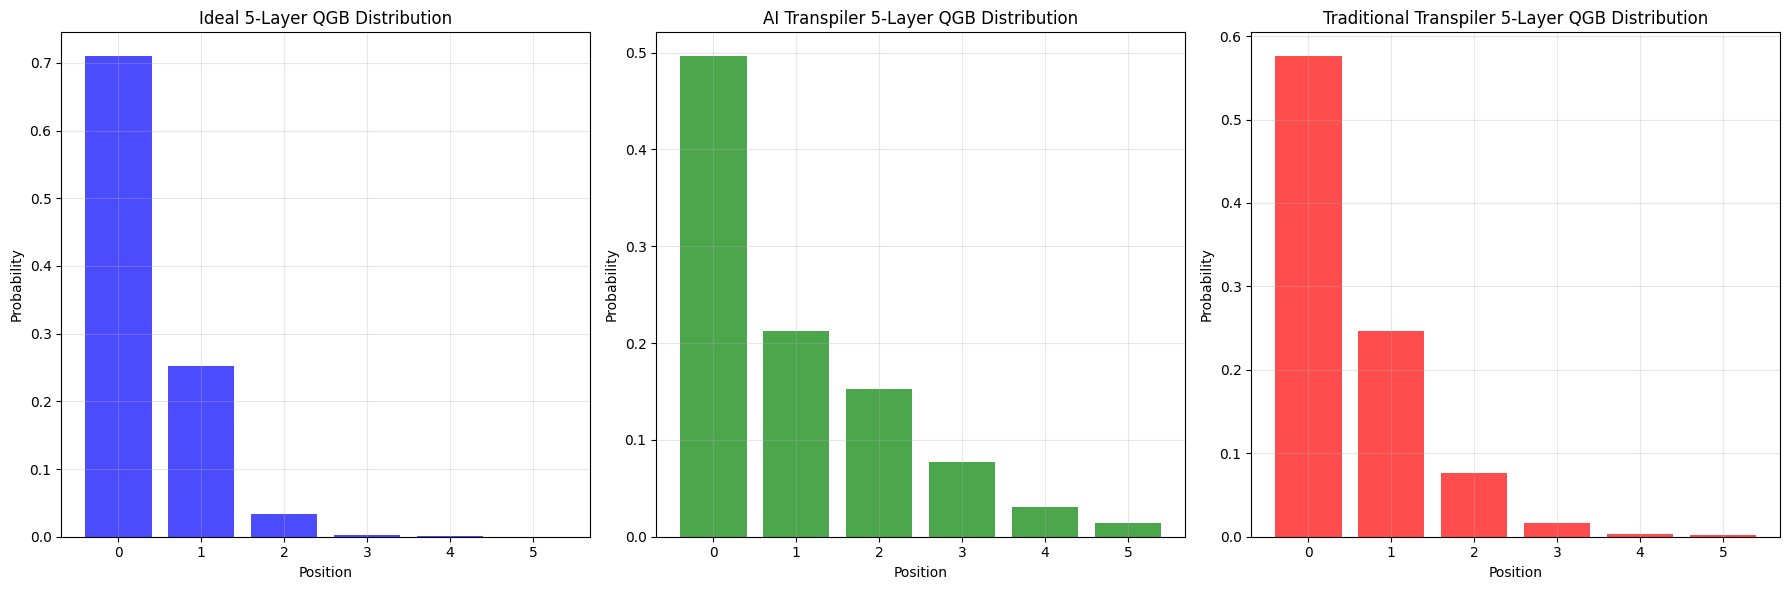

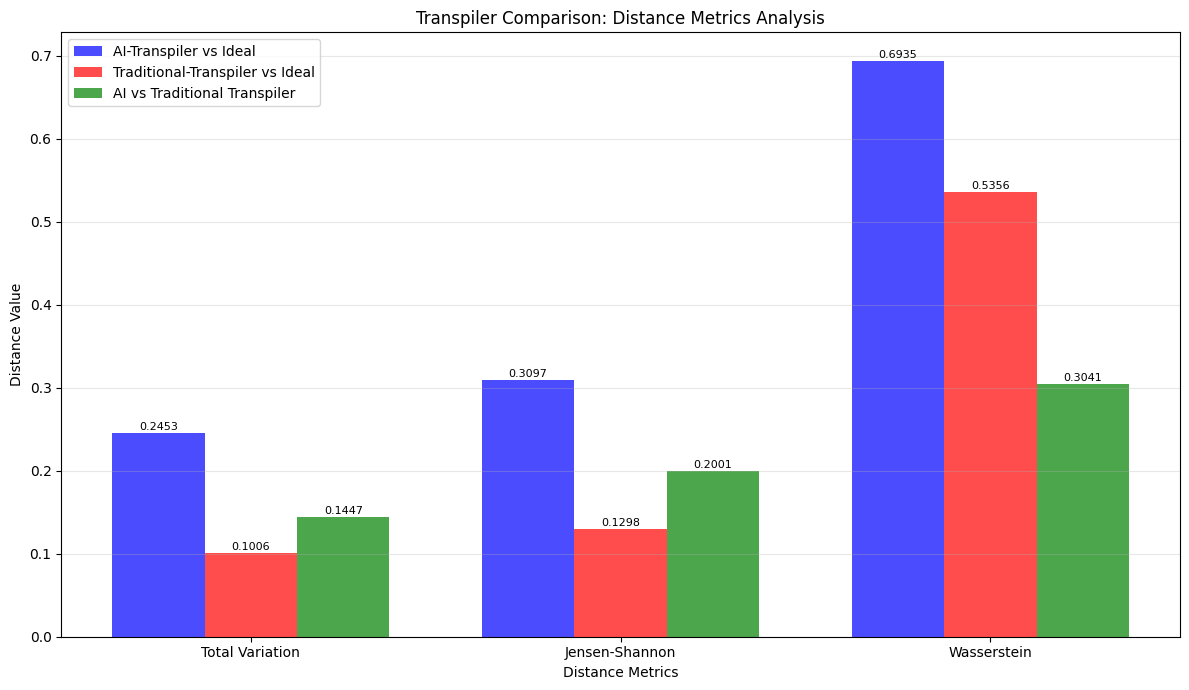


=== SUMMARY ===
AI vs Ideal - TVD: 0.2453, JSD: 0.3097, WD: 0.6935
Traditional vs Ideal - TVD: 0.1006, JSD: 0.1298, WD: 0.5356
AI vs Traditional - TVD: 0.1447, JSD: 0.2001, WD: 0.3041

All results and images saved in folder: 'torino-ai-transpiler-exponential'
Files saved:
  - 5_layers_qgb_three_methods.png (Distribution comparison)
  - transpiler_comparison_metrics.png (Distance metrics comparison)
  - three_method_results.txt (Detailed results)
  - Circuit diagrams: original, AI-transpiled, traditional-transpiled


In [44]:

# --- Main program execution with three-method comparison ---

if __name__ == '__main__':
    N_LAYERS = 5
    TEST_DEVICE = 'torino'
    SHOTS = 8192

    # Create the QGB circuit
    qgb_circuit = create_exponential_dist(N_LAYERS)

    # Prepare folder name
    folder_name = f"{TEST_DEVICE}-ai-transpiler-exponential"
    ensure_folder(folder_name)

    # Print circuit stats
    print(f"\n--- Circuit Information for {N_LAYERS}-Layer QGB ---")
    print(f"Circuit depth: {qgb_circuit.depth()}")
    print(f"Number of qubits: {qgb_circuit.num_qubits}")
    print(f"Number of classical bits: {qgb_circuit.num_clbits}\n")

    # Run three-method comparison
    (ideal_dist, ai_dist, trad_dist, ai_noise_model, trad_noise_model,
     ai_transpiled_circuit, trad_transpiled_circuit) = compare_three_methods(
        qgb_circuit, N_LAYERS, SHOTS, TEST_DEVICE)

    # Calculate distance metrics for all comparisons
    ai_vs_ideal = {
        'tvd': total_variation_distance(ai_dist, ideal_dist),
        'jsd': jensen_shannon_divergence(ai_dist, ideal_dist),
        'wd': wasserstein_distance(ai_dist, ideal_dist)
    }

    trad_vs_ideal = {
        'tvd': total_variation_distance(trad_dist, ideal_dist),
        'jsd': jensen_shannon_divergence(trad_dist, ideal_dist),
        'wd': wasserstein_distance(trad_dist, ideal_dist)
    }

    ai_vs_trad = {
        'tvd': total_variation_distance(ai_dist, trad_dist),
        'jsd': jensen_shannon_divergence(ai_dist, trad_dist),
        'wd': wasserstein_distance(ai_dist, trad_dist)
    }

    # Plot transpiler comparison metrics
    comparison_fig = plot_transpiler_comparison_metrics(ai_vs_ideal, trad_vs_ideal, ai_vs_trad)
    comparison_plot_path = os.path.join(folder_name, 'transpiler_comparison_metrics.png')
    comparison_fig.savefig(comparison_plot_path)

    if IS_IPYTHON:
        display(comparison_fig)
    else:
        plt.show()
    plt.close(comparison_fig)

    # Save results text file
    results_txt_path = os.path.join(folder_name, 'three_method_results.txt')
    save_three_method_results(results_txt_path, N_LAYERS, TEST_DEVICE,
                             ideal_dist, ai_dist, trad_dist,
                             ai_vs_ideal, trad_vs_ideal, ai_vs_trad,
                             ai_noise_model, trad_noise_model, qgb_circuit,
                             ai_transpiled_circuit, trad_transpiled_circuit)

    # Save circuit diagrams
    original_circuit_path = os.path.join(folder_name, 'original_circuit.png')
    ai_circuit_path = os.path.join(folder_name, 'ai_transpiled_circuit.png')
    trad_circuit_path = os.path.join(folder_name, 'traditional_transpiled_circuit.png')

    save_circuit_diagram(qgb_circuit, original_circuit_path)
    save_circuit_diagram(ai_transpiled_circuit, ai_circuit_path)
    save_circuit_diagram(trad_transpiled_circuit, trad_circuit_path)

    print(f"\n=== SUMMARY ===")
    print(f"AI vs Ideal - TVD: {ai_vs_ideal['tvd']:.4f}, JSD: {ai_vs_ideal['jsd']:.4f}, WD: {ai_vs_ideal['wd']:.4f}")
    print(f"Traditional vs Ideal - TVD: {trad_vs_ideal['tvd']:.4f}, JSD: {trad_vs_ideal['jsd']:.4f}, WD: {trad_vs_ideal['wd']:.4f}")
    print(f"AI vs Traditional - TVD: {ai_vs_trad['tvd']:.4f}, JSD: {ai_vs_trad['jsd']:.4f}, WD: {ai_vs_trad['wd']:.4f}")

    print(f"\nAll results and images saved in folder: '{folder_name}'")
    print(f"Files saved:")
    print(f"  - {N_LAYERS}_layers_qgb_three_methods.png (Distribution comparison)")
    print(f"  - transpiler_comparison_metrics.png (Distance metrics comparison)")
    print(f"  - three_method_results.txt (Detailed results)")
    print(f"  - Circuit diagrams: original, AI-transpiled, traditional-transpiled")

#The AI-transpiler did not show improvement over traditional transpilation in our experiments.